# Analysis of Bubble Tea Shops in DMV

### By Jason Chen

### CMSC 320 Final Tutorial

## Project Outline

1. Introduction
    * A. Background
    * B. Libraries Used
2. Data Collection
    * A. About the Dataset
    * b. Retrieving Dataset
3. Data Processing
4. Data Analysis
5. Conclusion

## 1. Introduction 

### 1A. Background

[Bubble tea](https://en.wikipedia.org/wiki/Bubble_tea) (also known as boba) is a Taiwanese tea-based drink invented in the 1980s. It most commonly consists of tea and comes with tapioca balls as toppings, but other toppings can be used as well such as coconut jelly, grass jelly, and red bean.
<script type="text/javascript" src="https://ssl.gstatic.com/trends_nrtr/2884_RC01/embed_loader.js"></script> <script type="text/javascript"> trends.embed.renderExploreWidget("TIMESERIES", {"comparisonItem":[{"keyword":"bubble tea","geo":"US","time":"2004-01-01 2022-05-07"}],"category":0,"property":""}, {"exploreQuery":"date=all&geo=US&q=bubble%20tea","guestPath":"https://trends.google.com:443/trends/embed/"}); </script>
The United States has recently witnessed a significant growth of the bubble tea market over the years. According to Google Trends, the popularity of Bubble tea in the United States has grown exponentially in the last few years.

In this tutorial, I will observe and analyze the potential trends of bubble tea shops in the DMV.

### 1B. Libraries Used
1. requests 
2. pandas
3. matplotlib
4. seaborn
5. folium
6. re

In [175]:
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import re

## 2. Data Collection

### 2A. About the Dataset
The dataset used in my analysis is retrieved using the Yelp Fusion API. Using the API I searched all boba/bubble tea shops within the DMV area (DC, Maryland, Virginia). I used the API's /businesses/search endpoint to get information about the business. The endpoint returns a json body that contains the business name, rating, price, review count, location, and other contact and miscellaneous information. 
Yelp's Fusion API allows many different parameters when calling the /businesses/search endpoint but for we only need to focus on limit, location, term, categories, and offset. 
Parameters: 
* limit, offset - used to iterate over all the businesses returned by the API call.
* location - used to filter bubble tea shops only in the DMV location.
* term, categories - used to filter searches to only those categorized as bubble tea shops.

In order to access and use the Yelp Fusion API, you need to create an app with Yelp to obtain an API key. To create one, follow the steps [here](https://www.yelp.com/developers/documentation/v3/authentication). 
Alternatively, to skip this step, I have downloaded the data I obtained from the API into a csv so it can be stored and used locally without having to access the API. 



In [176]:
api_key = '' # Enter your API key
def get_businesses(location, api_key):
  headers = {'Authorization': 'Bearer %s' % api_key}
  url = 'https://api.yelp.com/v3/businesses/search'
  data = []
  for offset in range(0, 1000, 50):
    params = {
        'limit': 50, 
        'location': location,
        'term' : 'bubble tea',
        'categories' : 'bubbletea, boba',
        'offset': offset
    }

    r = requests.get(url, headers=headers, params=params)
    if r.status_code == 200:
        data += r.json()['businesses']
    elif r.status_code == 400:
      print('400 Bad Request')
      break

  return data

## Data Wrangling

First I will call my function to request data from the API and then putting the data into a pandas dataframe for easily manipulation for my analysis. 

In [177]:
data = get_businesses("MD, Maryland, VA, Virginia, DC, Washington DC", api_key)

In [178]:
df = pd.DataFrame(data)
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,NBbDXp3rHgCJ0QUCfFJRmg,tan-cha-annandale-2,Tan-Cha,https://s3-media2.fl.yelpcdn.com/bphoto/poGLXm...,False,https://www.yelp.com/biz/tan-cha-annandale-2?a...,95,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}]",4.5,"{'latitude': 38.813181296474674, 'longitude': ...",[],$$,"{'address1': '6920A Bradlick Shopping Ctr', 'a...",+15713315843,(571) 331-5843,4943.928682
1,FR7sZVFKPmWlLcRZQcY_BQ,bobapop-tea-bar-merrifield-falls-church-2,BoBaPoP Tea Bar - Merrifield,https://s3-media4.fl.yelpcdn.com/bphoto/yna02R...,False,https://www.yelp.com/biz/bobapop-tea-bar-merri...,95,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...",4.5,"{'latitude': 38.8736868, 'longitude': -77.226773}",[],$$,"{'address1': '2831 Gallows Rd', 'address2': No...",+14348124173,(434) 812-4173,8009.090186
2,eS1iXKcOnpHc1GozXuve3g,gong-cha-annandale-7,Gong Cha,https://s3-media1.fl.yelpcdn.com/bphoto/9oWiQi...,False,https://www.yelp.com/biz/gong-cha-annandale-7?...,134,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.0,"{'latitude': 38.831325, 'longitude': -77.197176}","[pickup, delivery]",$$,"{'address1': '4230 Annandale Rd', 'address2': ...",+17033333117,(703) 333-3117,4856.757323
3,8cF3ogHF6F_UqTUovgUQsg,kung-fu-tea-burke,Kung Fu Tea,https://s3-media2.fl.yelpcdn.com/bphoto/zEr87j...,False,https://www.yelp.com/biz/kung-fu-tea-burke?adj...,71,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...",4.0,"{'latitude': 38.7783375368797, 'longitude': -7...","[pickup, delivery]",$,"{'address1': '9530B Old Keene Mill Rd', 'addre...",+17033725289,(703) 372-5289,3993.999083
4,XO4FhUW-MgS-T9BRfVKFVA,bubble-mochi-vienna,Bubble Mochi,https://s3-media4.fl.yelpcdn.com/bphoto/ehNw4V...,False,https://www.yelp.com/biz/bubble-mochi-vienna?a...,32,"[{'alias': 'donuts', 'title': 'Donuts'}, {'ali...",4.5,"{'latitude': 38.90042, 'longitude': -77.26714}",[],$$,"{'address1': '155 Maple Ave W', 'address2': 'U...",+15714075030,(571) 407-5030,11151.011538


The API returns several categories, some of which are not needed for the analysis so we will drop those. Categories such as coordinates and location are in the form of a json so we will seperate them into their own columns and drop any that are not needed.

In [179]:
df = df[df['is_closed'] == False]
df.drop(['id', 'is_closed', 'image_url', 'url', 'categories', 'phone', 'display_phone'], axis=1, inplace=True)
df_lat_lon = pd.json_normalize(df['coordinates'])
df_city_state = pd.json_normalize(df['location'])
df_city_state.drop(['address1', 'address2', 'address3', 'zip_code','country', 'display_address'], axis=1, inplace=True)
df

,alias,name,review_count,rating,coordinates,transactions,price,location,distance
0,tan-cha-annandale-2,Tan-Cha,95,4.5,"{'latitude': 38.813181296474674, 'longitude': ...",[],$$,"{'address1': '6920A Bradlick Shopping Ctr', 'a...",4943.928682
1,bobapop-tea-bar-merrifield-falls-church-2,BoBaPoP Tea Bar - Merrifield,95,4.5,"{'latitude': 38.8736868, 'longitude': -77.226773}",[],$$,"{'address1': '2831 Gallows Rd', 'address2': No...",8009.090186
2,gong-cha-annandale-7,Gong Cha,134,4.0,"{'latitude': 38.831325, 'longitude': -77.197176}","[pickup, delivery]",$$,"{'address1': '4230 Annandale Rd', 'address2': ...",4856.757323
3,kung-fu-tea-burke,Kung Fu Tea,71,4.0,"{'latitude': 38.7783375368797, 'longitude': -7...","[pickup, delivery]",$,"{'address1': '9530B Old Keene Mill Rd', 'addre...",3993.999083
4,bubble-mochi-vienna,Bubble Mochi,32,4.5,"{'latitude': 38.90042, 'longitude': -77.26714}",[],$$,"{'address1': '155 Maple Ave W', 'address2': 'U...",11151.011538
...,...,...,...,...,...,...,...,...,...
237,monster-tea-rockville,Monster Tea,10,3.0,"{'latitude': 39.05286, 'longitude': -77.12117}",[],NaN,"{'address1': None, 'address2': None, 'address3...",29832.520214
238,tea-com-gaithersburg,Tea.com,1,2.0,"{'latitude': 39.1526336669922, 'longitude': -7...",[],NaN,"{'address1': 'Lakeforest Mall', 'address2': No...",39028.231157
239,kokee-tea-at-arundel-mills-mall-hanover,Kokee Tea at Arundel Mills Mall,1,4.0,"{'latitude': 39.157807, 'longitude': -76.724818}",[],NaN,"{'address1': '7000 Arundel Mills Cir', 'addres...",59485.348639
240,asian-bakery-cafe-rockville,Asian Bakery Cafe,203,3.5,"{'latitude': 39.0934135, 'longitude': -77.1529...",[delivery],$,"{'address1': '763 Hungerford Dr', 'address2': ...",33191.712120


In [180]:
name_counts = df['name'].value_counts().reset_index()
name_counts = name_counts.rename(columns={'index':'name', 'name':'count'})

Split shop name by ' - ' to get names with ' - (City) '

In [181]:
format_names = []
for row in range(len(name_counts)):
    n = re.split(r'( \- )', name_counts['name'][row])[0].replace(' ', '').lower()
    format_names.append(n)  

name_counts = pd.concat([name_counts, pd.Series(format_names).rename('common_name')], axis=1)

In [182]:
name_counts['common_name'].value_counts()

bengong'stea               3
bobapopteabar              3
javaloco                   3
kokeetea                   3
gongcha                    2
                          ..
phovietfresh               1
jumbojumbocafeasiataste    1
t-swirlcrêpe               1
extraperkscoffeeshop       1
pandaexpress               1
Name: common_name, Length: 166, dtype: int64

List of the same bubble tea shop names that are spelled differently.

In [183]:
# List of duplicate names to be combined
is_duplicate = name_counts['common_name'].value_counts() > 1
duplicate_names = (is_duplicate.loc[is_duplicate].index).to_list()

print(*duplicate_names,sep='\n')

bengong'stea
bobapopteabar
javaloco
kokeetea
gongcha
vivibubbletea
jumbojumbocafe
sharetea
class520
mr.wish
tigersugar
kungfutea


In [184]:
name_counts = (name_counts.loc[name_counts['common_name'].isin(duplicate_names)]
                .sort_values(by='common_name'))

name_counts

,name,count,common_name
120,Ben Gong's Tea - Fairfax,1,bengong'stea
9,Ben Gong's Tea,2,bengong'stea
44,Bengong's Tea,1,bengong'stea
156,BoBaPoP Tea Bar - Merrifield,1,bobapopteabar
111,BoBaPoP Tea Bar - Kentlands,1,bobapopteabar
108,BobaPop Tea Bar - Germantown,1,bobapopteabar
58,Class 520 - Rockville,1,class520
28,Class 520,1,class520
65,Gong Cha - North Bethesda,1,gongcha
1,Gong Cha,15,gongcha


In [185]:
# Formatted names (lowercase & removed white space) back to shop names and any addition names to be hard coded ex. Names with city added to the end without separator
new_names = {
            'kokeetea' : 'Kokee Tea',
            'bobapopteabar' : 'BoBaPoP Tea Bar',
            'javaloco' : 'Java Loco',
            'kungfutea' : 'Kung Fu Tea',
            'mr.wish' : 'Mr. Wish',
            'tigersugar' : 'Tiger Sugar',
            'class520' : 'Class 520',
            'sharetea' : 'Share Tea',
            'vivibubbletea' : 'Vivi Bubble Tea',
            'jumbojumbocafe' : 'Jumbo Jumbo Cafe',
            "bengong'stea" : "Ben Gongs Teas",
            'gongcha' : 'Gong Cha'
            }

name_counts['common_name'] = name_counts['common_name'].replace(new_names)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(name_counts)

                              name  count       common_name
120       Ben Gong's Tea - Fairfax      1    Ben Gongs Teas
9                   Ben Gong's Tea      2    Ben Gongs Teas
44                   Bengong's Tea      1    Ben Gongs Teas
156   BoBaPoP Tea Bar - Merrifield      1   BoBaPoP Tea Bar
111    BoBaPoP Tea Bar - Kentlands      1   BoBaPoP Tea Bar
108   BobaPop Tea Bar - Germantown      1   BoBaPoP Tea Bar
58           Class 520 - Rockville      1         Class 520
28                       Class 520      1         Class 520
65       Gong Cha - North Bethesda      1          Gong Cha
1                         Gong Cha     15          Gong Cha
109                      Java Loco      1         Java Loco
152          Java Loco - Mt Vernon      1         Java Loco
79        Java Loco - Falls Church      1         Java Loco
48   Jumbo Jumbo Cafe - Germantown      1  Jumbo Jumbo Cafe
11                Jumbo Jumbo Cafe      2  Jumbo Jumbo Cafe
135                      Kokee tea      

In [186]:
# Dictionary of old names and correct shop names
replace_duplicates = dict(zip(name_counts['name'], name_counts['common_name']))
replace_duplicates

{"Ben Gong's Tea - Fairfax": 'Ben Gongs Teas',
 "Ben Gong's Tea": 'Ben Gongs Teas',
 "Bengong's Tea": 'Ben Gongs Teas',
 'BoBaPoP Tea Bar - Merrifield': 'BoBaPoP Tea Bar',
 'BoBaPoP Tea Bar - Kentlands': 'BoBaPoP Tea Bar',
 'BobaPop Tea Bar - Germantown': 'BoBaPoP Tea Bar',
 'Class 520 - Rockville': 'Class 520',
 'Class 520': 'Class 520',
 'Gong Cha - North Bethesda': 'Gong Cha',
 'Gong Cha': 'Gong Cha',
 'Java Loco': 'Java Loco',
 'Java Loco - Mt Vernon': 'Java Loco',
 'Java Loco - Falls Church': 'Java Loco',
 'Jumbo Jumbo Cafe - Germantown': 'Jumbo Jumbo Cafe',
 'Jumbo Jumbo Cafe': 'Jumbo Jumbo Cafe',
 'Kokee tea': 'Kokee Tea',
 'Kokee Tea': 'Kokee Tea',
 'Kokee Tea - Annapolis': 'Kokee Tea',
 'Kung Fu Tea - Ellicott City': 'Kung Fu Tea',
 'Kung Fu Tea': 'Kung Fu Tea',
 'Mr.Wish': 'Mr. Wish',
 'Mr. Wish': 'Mr. Wish',
 'Sharetea': 'Share Tea',
 'Sharetea ': 'Share Tea',
 'TIGER SUGAR': 'Tiger Sugar',
 'Tiger Sugar': 'Tiger Sugar',
 'ViVi Bubble Tea': 'Vivi Bubble Tea',
 'Vivi Bubble T

Here we replace the duplicate names and then replalce those that went through the inital parsing

In [187]:
# Combine same bubble tea shop with different names into correct shop name
df['name'] = df['name'].replace(replace_duplicates)

extra_names = {
    'Ben Gong’s Tea - Annandale' : 'Ben Gongs Teas',
    'Kung Fu Tea II' : 'Kung Fu Tea',
    'Kokee Tea at Arundel Mills Mall' : 'Kokee Tea',
    'Gong Cha Arundel Mills' : 'Gong Cha',
    'Gong Cha Chantilly' : 'Gong Cha',
    'Gongcha Arlington' : ' Gong Cha',
    'Tea-Do Ellicott City' : 'Tea-Do',
    'Chatime Federal Hill' : 'Chatime',
    'ChaTime White Marsh' : 'Chatime',
    'Jumbo Jumbo Cafe Asia Taste' : 'Jumbo Jumbo Cafe',
    "Jasmine's Smoothie World" : 'Jasmine Smoothie World And Bubble Tea'

}
df['name'] = df['name'].replace(extra_names)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'expand_frame_repr', False):
#   print(df)

In [188]:
df['name'].value_counts()

Kung Fu Tea                       30
Gong Cha                          18
Kokee Tea                          9
Ben Gongs Teas                     5
Jumbo Jumbo Cafe                   4
                                  ..
Moge Tee                           1
Donutchew - Fair Oaks Mall         1
Supreme Barbeque - AunTea Boba     1
Lily Bubble Tea and Smoothie       1
Panda Express                      1
Name: name, Length: 157, dtype: int64

## 3. Data Processing

We will use Pandas' describe() function to generate some descriptive statistics. 

In [189]:
df.describe()

,review_count,rating,distance
count,242.000000,242.000000,242.000000
mean,108.842975,4.016529,33293.375667
std,150.274273,0.553877,22750.917934
min,1.000000,2.000000,3438.579768
25%,21.250000,3.500000,16720.021901
50%,62.000000,4.000000,29935.697512
75%,128.000000,4.500000,42182.862118
max,1197.000000,5.000000,92143.504111


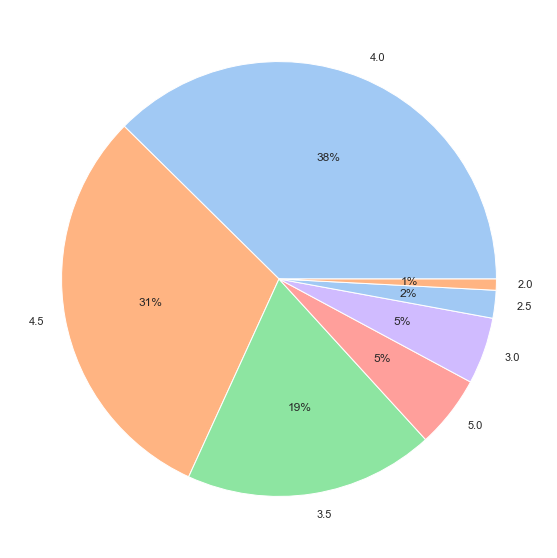

In [287]:
rating_count = df['rating'].value_counts().to_frame().reset_index()
rating_count = rating_count.rename(columns={'index':'rating', 'rating':'count'})
rating_count
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 10))
plt.pie(rating_count['count'], labels = rating_count['rating'], colors = colors, autopct='%.0f%%');

C:\Users\Jason\AppData\Local\Temp\ipykernel_49560\3750420664.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  plt.pie(price_count['count'], labels = price_count['name'].str.replace('\$', '\\$'), colors = colors, autopct='%.0f%%');


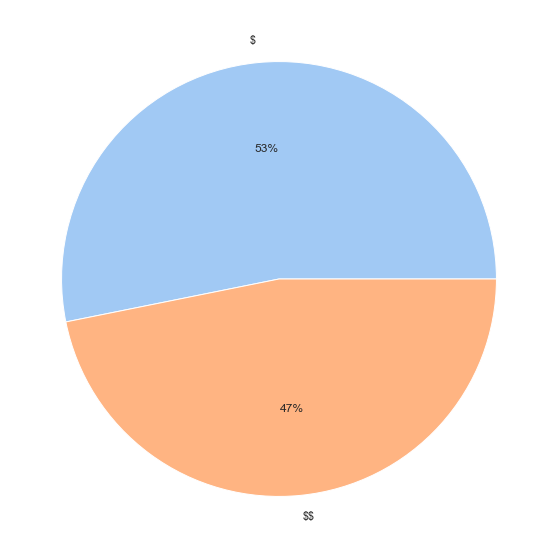

In [293]:
price_count = df['price'].value_counts().reset_index()
price_count = price_count.rename(columns={'index':'name', 'price':'count'})
# price_count
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 10))
plt.pie(price_count['count'], labels = price_count['name'].str.replace('\$', '\\$'), colors = colors, autopct='%.0f%%');

                            name  rating  review_count
133  Teas'n You Fusion Tea House     4.5        1197.0
130        Teaism - Penn Quarter     3.5         778.0
103             SnoCream Company     4.5         756.0
105                     SnowBots     3.5         722.0
131         Teaism Dupont Circle     4.0         720.0
..                           ...     ...           ...
59            Juno Bakery & Cafe     4.5           2.0
56      Jin Bubble Tea & Smothie     2.5           2.0
9                    Awesome Pho     3.0           2.0
125                      Tea.com     2.0           1.0
111   Sweeties Novelty Brewhouse     5.0           1.0

[157 rows x 3 columns]


<module 'seaborn' from 'C:\\Users\\Jason\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

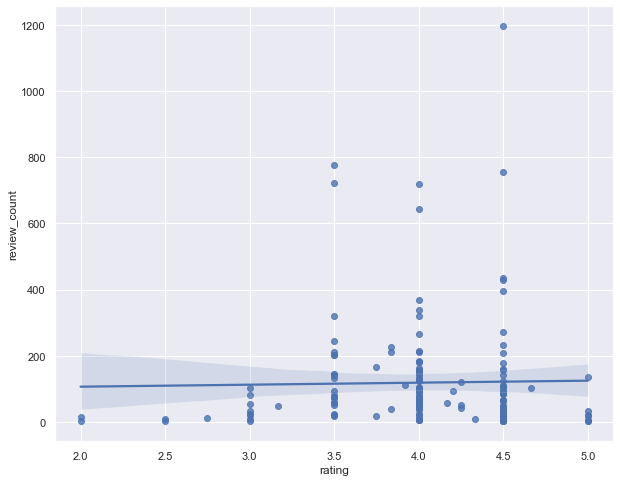

In [294]:
mean_rating = df.groupby(['name'])['rating'].mean()
mean_review_count = df.groupby(['name'])['review_count'].mean()

mean_rating_df = mean_rating.to_frame().reset_index()
mean_review_count_df = mean_review_count.to_frame().reset_index()

res = pd.merge(mean_rating_df, mean_review_count_df, on="name")
res.sort_values(by=['review_count'], ascending=False, inplace=True)
print(res)
sns.set_theme(color_codes=True)
plt.figure(figsize=(10,8))
sns.regplot(x = res['rating'], y = res['review_count']);
sns

<module 'seaborn' from 'C:\\Users\\Jason\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

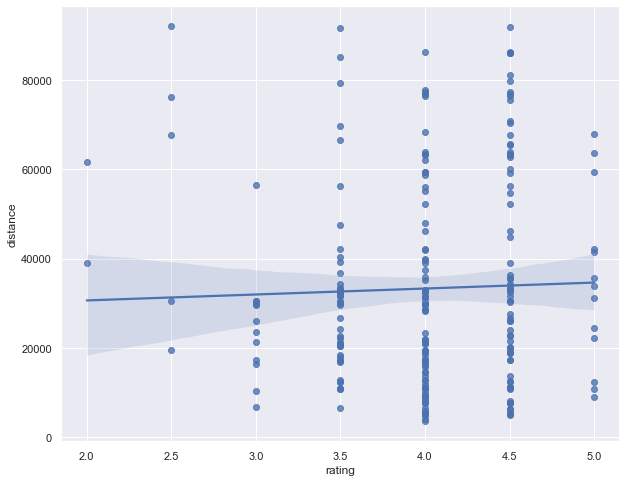

In [295]:
plt.figure(figsize=(10,8))
# sns.scatterplot(x = df['rating'], y = df['price'].str.replace('\$\$','\\$\\$'))
sns.regplot(x = 'rating', y = 'distance', data=df);
sns

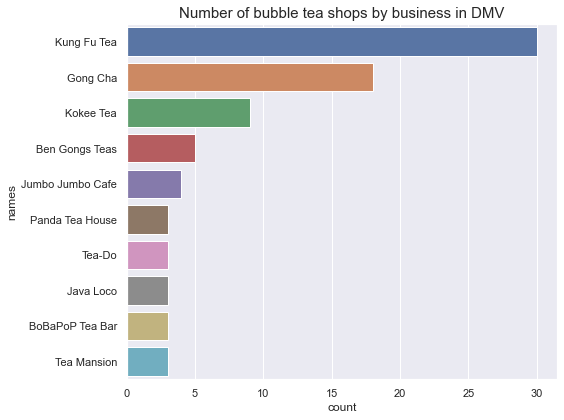

In [296]:
name_counts = df['name'].value_counts().reset_index(drop=False)
name_counts = name_counts.rename(columns={'index':'names', 'name':'count'})

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='count',
            y='names', 
            data=name_counts.head(10), 
            ax=ax)

plt.title('Number of bubble tea shops by business in DMV', fontsize=15)
plt.tight_layout()

Since we are given coordinates from our dataset. Let's plot it on a map so we can visualize it better.

In [297]:
map_osm = folium.Map(location=[38.90, -77.03], zoom_start=10)
# df['coordinates']
for _, shop in df.iterrows():
  if shop['rating'] == 5:
    folium.Marker(location=[(shop['coordinates'])['latitude'], (shop['coordinates'])['longitude']],
                icon=folium.Icon(color='beige'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)
  elif shop['rating'] == 4 or shop['rating'] == 4.5 :
    folium.Marker(location=[(shop['coordinates'])['latitude'], (shop['coordinates'])['longitude']],
                icon=folium.Icon(color='purple'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)
  elif shop['rating'] == 3 or shop['rating'] == 3.5 :
    folium.Marker(location=[(shop['coordinates'])['latitude'], (shop['coordinates'])['longitude']],
                icon=folium.Icon(color='blue'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)
  elif shop['rating'] <= 2.5:
    folium.Marker(location=[(shop['coordinates'])['latitude'], (shop['coordinates'])['longitude']],
                icon=folium.Icon(color='red'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)       

map_osm